In [1]:
# ============================================
# CELL 1: Setup and Data Loading
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                           roc_auc_score, roc_curve, precision_recall_curve,
                           accuracy_score, precision_score, recall_score, f1_score)

# Advanced Models
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("⚠️ XGBoost not available - will use other models")

# Model Interpretation
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
    print("⚠️ SHAP not available - will skip advanced interpretation")

import joblib
import json
import os

print("🤖 CUSTOMER CHURN PREDICTION - MODEL TRAINING")
print("=" * 60)

# Load processed data
print("📊 Loading processed data...")

X = pd.read_csv('../data/processed/features.csv')
y = pd.read_csv('../data/processed/target.csv').squeeze()  # Convert to Series

print(f"✅ Data loaded successfully!")
print(f"📊 Features shape: {X.shape}")
print(f"🎯 Target shape: {y.shape}")
print(f"📈 Churn rate: {y.mean():.2%}")

# Load feature names
with open('../data/processed/feature_names.txt', 'r') as f:
    feature_names = [line.strip() for line in f.readlines()]

print(f"📋 Features loaded: {len(feature_names)}")

# Quick data check
print(f"\n🔍 Data Quality Check:")
print(f"   Missing values in X: {X.isnull().sum().sum()}")
print(f"   Missing values in y: {y.isnull().sum()}")
print(f"   Feature data types: {X.dtypes.value_counts().to_dict()}")


🤖 CUSTOMER CHURN PREDICTION - MODEL TRAINING
📊 Loading processed data...
✅ Data loaded successfully!
📊 Features shape: (7043, 65)
🎯 Target shape: (7043,)
📈 Churn rate: 26.54%
📋 Features loaded: 65

🔍 Data Quality Check:
   Missing values in X: 0
   Missing values in y: 0
   Feature data types: {dtype('int64'): 37, dtype('bool'): 17, dtype('float64'): 11}


In [2]:
# ============================================
# CELL 2: Data Preparation and Splitting
# ============================================

print("🔄 DATA PREPARATION & SPLITTING")
print("=" * 40)

# Check class distribution
class_distribution = y.value_counts()
print(f"📊 Class Distribution:")
print(f"   No Churn (0): {class_distribution[0]:,} ({class_distribution[0]/len(y):.1%})")
print(f"   Churn (1): {class_distribution[1]:,} ({class_distribution[1]/len(y):.1%})")

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n📊 Data Split:")
print(f"   Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X):.1%})")
print(f"   Test set: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X):.1%})")

# Verify stratification
train_churn_rate = y_train.mean()
test_churn_rate = y_test.mean()
print(f"\n🎯 Churn Rate Verification:")
print(f"   Training: {train_churn_rate:.2%}")
print(f"   Test: {test_churn_rate:.2%}")
print(f"   ✅ Stratification {'successful' if abs(train_churn_rate - test_churn_rate) < 0.02 else 'needs adjustment'}")

# Feature scaling for models that need it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n🔧 Feature Scaling:")
print(f"   Scaler fitted on training data")
print(f"   Training features scaled: {X_train_scaled.shape}")
print(f"   Test features scaled: {X_test_scaled.shape}")

# Convert back to DataFrame for easier handling
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print(f"\n✅ Data preparation complete!")


🔄 DATA PREPARATION & SPLITTING
📊 Class Distribution:
   No Churn (0): 5,174 (73.5%)
   Churn (1): 1,869 (26.5%)

📊 Data Split:
   Training set: 5,634 samples (80.0%)
   Test set: 1,409 samples (20.0%)

🎯 Churn Rate Verification:
   Training: 26.54%
   Test: 26.54%
   ✅ Stratification successful

🔧 Feature Scaling:
   Scaler fitted on training data
   Training features scaled: (5634, 65)
   Test features scaled: (1409, 65)

✅ Data preparation complete!


In [4]:
# ============================================
# CELL 3: Model Training - Logistic Regression
# ============================================

print("📈 MODEL 1: LOGISTIC REGRESSION")
print("=" * 40)

# Train Logistic Regression
print("🔄 Training Logistic Regression...")

lr_model = LogisticRegression(
    random_state=42, 
    max_iter=1000,
    class_weight='balanced'  # Handle class imbalance
)

lr_model.fit(X_train_scaled_df, y_train)

# Predictions
lr_train_pred = lr_model.predict(X_train_scaled_df)
lr_test_pred = lr_model.predict(X_test_scaled_df)
lr_train_proba = lr_model.predict_proba(X_train_scaled_df)[:, 1]
lr_test_proba = lr_model.predict_proba(X_test_scaled_df)[:, 1]

# Evaluation
lr_train_acc = accuracy_score(y_train, lr_train_pred)
lr_test_acc = accuracy_score(y_test, lr_test_pred)
lr_train_auc = roc_auc_score(y_train, lr_train_proba)
lr_test_auc = roc_auc_score(y_test, lr_test_proba)

print(f"📊 Logistic Regression Results:")
print(f"   Training Accuracy: {lr_train_acc:.3f}")
print(f"   Test Accuracy: {lr_test_acc:.3f}")
print(f"   Training AUC: {lr_train_auc:.3f}")
print(f"   Test AUC: {lr_test_auc:.3f}")

# Detailed classification report
print(f"\n📋 Detailed Classification Report (Test Set):")
print(classification_report(y_test, lr_test_pred, target_names=['No Churn', 'Churn']))

# Cross-validation
cv_scores = cross_val_score(lr_model, X_train_scaled_df, y_train, cv=5, scoring='roc_auc')
print(f"\n🔄 5-Fold Cross-Validation AUC: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

print(f"✅ Logistic Regression training complete!")


📈 MODEL 1: LOGISTIC REGRESSION
🔄 Training Logistic Regression...
📊 Logistic Regression Results:
   Training Accuracy: 0.758
   Test Accuracy: 0.751
   Training AUC: 0.854
   Test AUC: 0.845

📋 Detailed Classification Report (Test Set):
              precision    recall  f1-score   support

    No Churn       0.91      0.73      0.81      1035
       Churn       0.52      0.80      0.63       374

    accuracy                           0.75      1409
   macro avg       0.72      0.77      0.72      1409
weighted avg       0.81      0.75      0.76      1409


🔄 5-Fold Cross-Validation AUC: 0.848 (+/- 0.030)
✅ Logistic Regression training complete!


In [5]:
# ============================================
# CELL 4: Model Training - Random Forest
# ============================================

print("🌳 MODEL 2: RANDOM FOREST")
print("=" * 35)

# Train Random Forest
print("🔄 Training Random Forest...")

rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced',
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2
)

rf_model.fit(X_train, y_train)  # Random Forest doesn't need scaling

# Predictions
rf_train_pred = rf_model.predict(X_train)
rf_test_pred = rf_model.predict(X_test)
rf_train_proba = rf_model.predict_proba(X_train)[:, 1]
rf_test_proba = rf_model.predict_proba(X_test)[:, 1]

# Evaluation
rf_train_acc = accuracy_score(y_train, rf_train_pred)
rf_test_acc = accuracy_score(y_test, rf_test_pred)
rf_train_auc = roc_auc_score(y_train, rf_train_proba)
rf_test_auc = roc_auc_score(y_test, rf_test_proba)

print(f"📊 Random Forest Results:")
print(f"   Training Accuracy: {rf_train_acc:.3f}")
print(f"   Test Accuracy: {rf_test_acc:.3f}")
print(f"   Training AUC: {rf_train_auc:.3f}")
print(f"   Test AUC: {rf_test_auc:.3f}")

# Detailed classification report
print(f"\n📋 Detailed Classification Report (Test Set):")
print(classification_report(y_test, rf_test_pred, target_names=['No Churn', 'Churn']))

# Cross-validation
cv_scores_rf = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='roc_auc')
print(f"\n🔄 5-Fold Cross-Validation AUC: {cv_scores_rf.mean():.3f} (+/- {cv_scores_rf.std() * 2:.3f})")

print(f"✅ Random Forest training complete!")


🌳 MODEL 2: RANDOM FOREST
🔄 Training Random Forest...
📊 Random Forest Results:
   Training Accuracy: 0.850
   Test Accuracy: 0.771
   Training AUC: 0.940
   Test AUC: 0.843

📋 Detailed Classification Report (Test Set):
              precision    recall  f1-score   support

    No Churn       0.89      0.78      0.83      1035
       Churn       0.55      0.73      0.63       374

    accuracy                           0.77      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.80      0.77      0.78      1409


🔄 5-Fold Cross-Validation AUC: 0.842 (+/- 0.026)
✅ Random Forest training complete!


In [6]:
# ============================================
# CELL 5: Model Training - XGBoost (if available)
# ============================================

if XGBOOST_AVAILABLE:
    print("🚀 MODEL 3: XGBOOST")
    print("=" * 30)
    
    # Train XGBoost
    print("🔄 Training XGBoost...")
    
    # Calculate scale_pos_weight for imbalanced data
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        random_state=42,
        scale_pos_weight=scale_pos_weight,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss'
    )
    
    xgb_model.fit(X_train, y_train)
    
    # Predictions
    xgb_train_pred = xgb_model.predict(X_train)
    xgb_test_pred = xgb_model.predict(X_test)
    xgb_train_proba = xgb_model.predict_proba(X_train)[:, 1]
    xgb_test_proba = xgb_model.predict_proba(X_test)[:, 1]
    
    # Evaluation
    xgb_train_acc = accuracy_score(y_train, xgb_train_pred)
    xgb_test_acc = accuracy_score(y_test, xgb_test_pred)
    xgb_train_auc = roc_auc_score(y_train, xgb_train_proba)
    xgb_test_auc = roc_auc_score(y_test, xgb_test_proba)
    
    print(f"📊 XGBoost Results:")
    print(f"   Training Accuracy: {xgb_train_acc:.3f}")
    print(f"   Test Accuracy: {xgb_test_acc:.3f}")
    print(f"   Training AUC: {xgb_train_auc:.3f}")
    print(f"   Test AUC: {xgb_test_auc:.3f}")
    
    # Detailed classification report
    print(f"\n📋 Detailed Classification Report (Test Set):")
    print(classification_report(y_test, xgb_test_pred, target_names=['No Churn', 'Churn']))
    
    # Cross-validation
    cv_scores_xgb = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='roc_auc')
    print(f"\n🔄 5-Fold Cross-Validation AUC: {cv_scores_xgb.mean():.3f} (+/- {cv_scores_xgb.std() * 2:.3f})")
    
    print(f"✅ XGBoost training complete!")
else:
    print("⚠️ XGBoost not available - skipping")


🚀 MODEL 3: XGBOOST
🔄 Training XGBoost...
📊 XGBoost Results:
   Training Accuracy: 0.864
   Test Accuracy: 0.750
   Training AUC: 0.953
   Test AUC: 0.837

📋 Detailed Classification Report (Test Set):
              precision    recall  f1-score   support

    No Churn       0.88      0.76      0.82      1035
       Churn       0.52      0.72      0.61       374

    accuracy                           0.75      1409
   macro avg       0.70      0.74      0.71      1409
weighted avg       0.79      0.75      0.76      1409


🔄 5-Fold Cross-Validation AUC: 0.833 (+/- 0.023)
✅ XGBoost training complete!


📊 MODEL COMPARISON & EVALUATION
📋 Model Comparison Summary:
                 Model  Test_Accuracy  Test_AUC  CV_AUC_Mean  CV_AUC_Std  \
0  Logistic Regression          0.751     0.845        0.848       0.015   
1        Random Forest          0.771     0.843        0.842       0.013   
2              XGBoost          0.750     0.837        0.833       0.012   

   Overfitting  
0        0.009  
1        0.098  
2        0.116  

🏆 Best Model: Logistic Regression
   Test AUC: 0.845
   Test Accuracy: 0.751
   CV AUC: 0.848 (+/- 0.015)


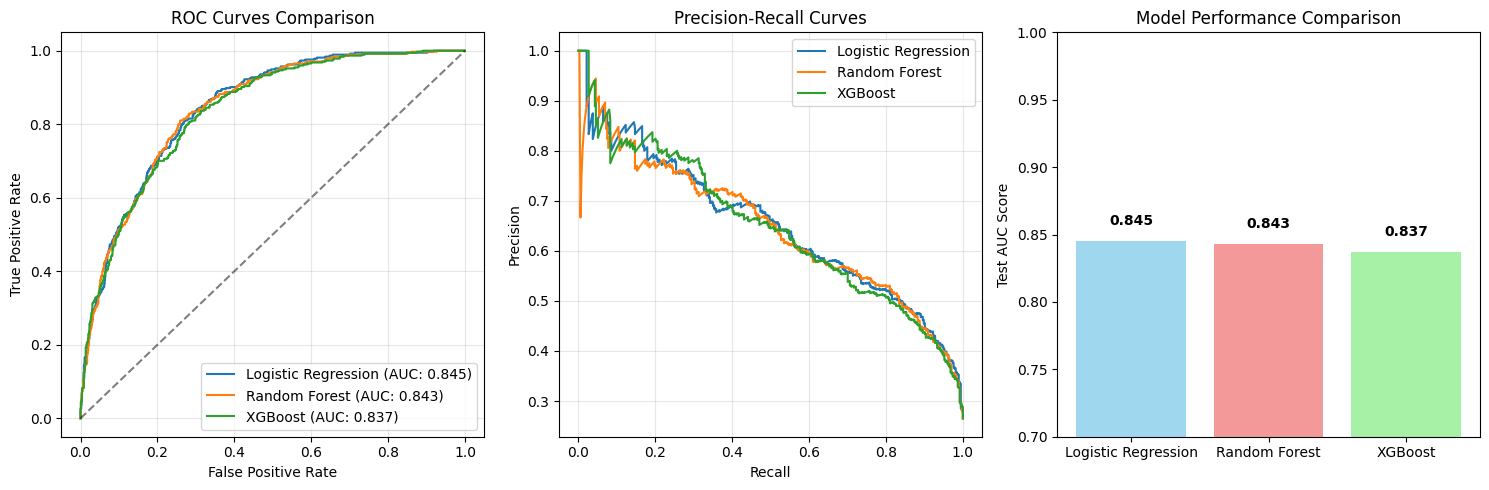

In [7]:
# ============================================
# CELL 6: Model Comparison and Evaluation
# ============================================

print("📊 MODEL COMPARISON & EVALUATION")
print("=" * 45)

# Compile results
models_results = {
    'Logistic Regression': {
        'train_acc': lr_train_acc, 'test_acc': lr_test_acc,
        'train_auc': lr_train_auc, 'test_auc': lr_test_auc,
        'cv_auc_mean': cv_scores.mean(), 'cv_auc_std': cv_scores.std(),
        'test_proba': lr_test_proba, 'test_pred': lr_test_pred,
        'model': lr_model
    },
    'Random Forest': {
        'train_acc': rf_train_acc, 'test_acc': rf_test_acc,
        'train_auc': rf_train_auc, 'test_auc': rf_test_auc,
        'cv_auc_mean': cv_scores_rf.mean(), 'cv_auc_std': cv_scores_rf.std(),
        'test_proba': rf_test_proba, 'test_pred': rf_test_pred,
        'model': rf_model
    }
}

if XGBOOST_AVAILABLE:
    models_results['XGBoost'] = {
        'train_acc': xgb_train_acc, 'test_acc': xgb_test_acc,
        'train_auc': xgb_train_auc, 'test_auc': xgb_test_auc,
        'cv_auc_mean': cv_scores_xgb.mean(), 'cv_auc_std': cv_scores_xgb.std(),
        'test_proba': xgb_test_proba, 'test_pred': xgb_test_pred,
        'model': xgb_model
    }

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': list(models_results.keys()),
    'Test_Accuracy': [results['test_acc'] for results in models_results.values()],
    'Test_AUC': [results['test_auc'] for results in models_results.values()],
    'CV_AUC_Mean': [results['cv_auc_mean'] for results in models_results.values()],
    'CV_AUC_Std': [results['cv_auc_std'] for results in models_results.values()],
    'Overfitting': [results['train_auc'] - results['test_auc'] for results in models_results.values()]
})

print("📋 Model Comparison Summary:")
print(comparison_df.round(3))

# Find best model
best_model_name = comparison_df.loc[comparison_df['Test_AUC'].idxmax(), 'Model']
best_model_results = models_results[best_model_name]

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Test AUC: {best_model_results['test_auc']:.3f}")
print(f"   Test Accuracy: {best_model_results['test_acc']:.3f}")
print(f"   CV AUC: {best_model_results['cv_auc_mean']:.3f} (+/- {best_model_results['cv_auc_std']:.3f})")

# ROC Curve Comparison
plt.figure(figsize=(15, 5))

# ROC Curves
plt.subplot(1, 3, 1)
for model_name, results in models_results.items():
    fpr, tpr, _ = roc_curve(y_test, results['test_proba'])
    plt.plot(fpr, tpr, label=f"{model_name} (AUC: {results['test_auc']:.3f})")

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(alpha=0.3)

# Precision-Recall Curves
plt.subplot(1, 3, 2)
for model_name, results in models_results.items():
    precision, recall, _ = precision_recall_curve(y_test, results['test_proba'])
    plt.plot(recall, precision, label=f"{model_name}")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.grid(alpha=0.3)

# Model Performance Comparison
plt.subplot(1, 3, 3)
models = list(models_results.keys())
test_aucs = [results['test_auc'] for results in models_results.values()]
colors = ['skyblue', 'lightcoral', 'lightgreen'][:len(models)]

bars = plt.bar(models, test_aucs, color=colors, alpha=0.8)
plt.ylabel('Test AUC Score')
plt.title('Model Performance Comparison')
plt.ylim(0.7, 1.0)

# Add value labels on bars
for bar, auc in zip(bars, test_aucs):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{auc:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


In [8]:

# ============================================
# CELL 7: Feature Importance Analysis
# ============================================

print("🎯 FEATURE IMPORTANCE ANALYSIS")
print("=" * 40)

# Get feature importance from best tree-based model
if best_model_name in ['Random Forest', 'XGBoost']:
    best_model = best_model_results['model']
    
    if best_model_name == 'Random Forest':
        feature_importance = best_model.feature_importances_
    else:  # XGBoost
        feature_importance = best_model.feature_importances_
    
    # Create feature importance DataFrame
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)
    
    print(f"🔝 Top 15 Most Important Features ({best_model_name}):")
    print(feature_importance_df.head(15).to_string(index=False, float_format='%.4f'))
    
    # Visualize top features
    plt.figure(figsize=(12, 8))
    top_features = feature_importance_df.head(20)
    
    plt.barh(range(len(top_features)), top_features['Importance'], color='steelblue', alpha=0.8)
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 20 Feature Importance - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
elif best_model_name == 'Logistic Regression':
    # For logistic regression, use coefficient magnitude
    coefficients = abs(lr_model.coef_[0])
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': coefficients
    }).sort_values('Importance', ascending=False)
    
    print(f"🔝 Top 15 Most Important Features (Logistic Regression - Coefficient Magnitude):")
    print(feature_importance_df.head(15).to_string(index=False, float_format='%.4f'))

# Business insights from feature importance
print(f"\n💡 KEY BUSINESS INSIGHTS:")
top_5_features = feature_importance_df.head(5)['Feature'].tolist()
print(f"🎯 Top 5 Churn Predictors:")
for i, feature in enumerate(top_5_features, 1):
    print(f"   {i}. {feature}")



🎯 FEATURE IMPORTANCE ANALYSIS
🔝 Top 15 Most Important Features (Logistic Regression - Coefficient Magnitude):
                        Feature  Importance
             avg_monthly_charge      0.7522
                 MonthlyCharges      0.6271
            low_monthly_charges      0.4064
           Internet_Fiber optic      0.3654
                   Internet_DSL      0.3068
               premium_services      0.3053
InternetService_risk_normalized      0.2789
           InternetService_risk      0.2789
       revenue_per_tenure_month      0.2693
             StreamingTV_binary      0.2679
         StreamingMovies_binary      0.2672
                is_new_customer      0.2490
           MultipleLines_binary      0.2483
                   tenure_years      0.2281
                         tenure      0.2281

💡 KEY BUSINESS INSIGHTS:
🎯 Top 5 Churn Predictors:
   1. avg_monthly_charge
   2. MonthlyCharges
   3. low_monthly_charges
   4. Internet_Fiber optic
   5. Internet_DSL


In [9]:
# ============================================
# CELL 8: Business Impact Analysis
# ============================================

print("💰 BUSINESS IMPACT ANALYSIS")
print("=" * 35)

# Use best model for business analysis
best_test_proba = best_model_results['test_proba']
best_test_pred = best_model_results['test_pred']

# Confusion Matrix Analysis
cm = confusion_matrix(y_test, best_test_pred)
tn, fp, fn, tp = cm.ravel()

print(f"📊 Confusion Matrix Analysis ({best_model_name}):")
print(f"   True Negatives (Correct - No Churn): {tn}")
print(f"   False Positives (Wrong - Predicted Churn): {fp}")
print(f"   False Negatives (Wrong - Missed Churn): {fn}")
print(f"   True Positives (Correct - Predicted Churn): {tp}")

# Business metrics
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

print(f"\n📈 Business Performance Metrics:")
print(f"   Precision (Churn Prediction Accuracy): {precision:.2%}")
print(f"   Recall (Churn Detection Rate): {recall:.2%}")
print(f"   Specificity (Loyal Customer Retention): {specificity:.2%}")

# Calculate business impact if we have charge information
if 'MonthlyCharges' in X_test.columns:
    # Get actual monthly charges for test set
    test_monthly_charges = X_test['MonthlyCharges']
    
    # Revenue impact analysis
    actual_churned_revenue = test_monthly_charges[y_test == 1].sum()
    predicted_churned_revenue = test_monthly_charges[best_test_pred == 1].sum()
    
    # Revenue saved by correct predictions
    correctly_identified_churners = (y_test == 1) & (best_test_pred == 1)
    revenue_at_risk_identified = test_monthly_charges[correctly_identified_churners].sum()
    
    print(f"\n💰 Revenue Impact Analysis:")
    print(f"   Actual monthly revenue lost to churn: ${actual_churned_revenue:,.2f}")
    print(f"   Revenue at risk identified by model: ${revenue_at_risk_identified:,.2f}")
    print(f"   Model effectiveness: {(revenue_at_risk_identified/actual_churned_revenue):.1%}")
    
    # Potential savings calculation (assuming 50% retention success rate)
    retention_success_rate = 0.5  # Assume 50% of interventions succeed
    potential_monthly_savings = revenue_at_risk_identified * retention_success_rate
    annual_savings_potential = potential_monthly_savings * 12
    
    print(f"\n🎯 Intervention Potential (50% success rate assumption):")
    print(f"   Monthly revenue potentially saved: ${potential_monthly_savings:,.2f}")
    print(f"   Annual revenue potentially saved: ${annual_savings_potential:,.2f}")

# Model confidence analysis
print(f"\n📊 Model Confidence Analysis:")
high_confidence_threshold = 0.8
low_confidence_threshold = 0.2

high_conf_churn = (best_test_proba >= high_confidence_threshold).sum()
low_conf_churn = (best_test_proba <= low_confidence_threshold).sum()
medium_conf = len(best_test_proba) - high_conf_churn - low_conf_churn

print(f"   High confidence churn predictions (>{high_confidence_threshold:.0%}): {high_conf_churn}")
print(f"   Low confidence churn predictions (<{low_confidence_threshold:.0%}): {low_conf_churn}")
print(f"   Medium confidence predictions: {medium_conf}")


💰 BUSINESS IMPACT ANALYSIS
📊 Confusion Matrix Analysis (Logistic Regression):
   True Negatives (Correct - No Churn): 757
   False Positives (Wrong - Predicted Churn): 278
   False Negatives (Wrong - Missed Churn): 73
   True Positives (Correct - Predicted Churn): 301

📈 Business Performance Metrics:
   Precision (Churn Prediction Accuracy): 51.99%
   Recall (Churn Detection Rate): 80.48%
   Specificity (Loyal Customer Retention): 73.14%

💰 Revenue Impact Analysis:
   Actual monthly revenue lost to churn: $27,214.90
   Revenue at risk identified by model: $22,587.20
   Model effectiveness: 83.0%

🎯 Intervention Potential (50% success rate assumption):
   Monthly revenue potentially saved: $11,293.60
   Annual revenue potentially saved: $135,523.20

📊 Model Confidence Analysis:
   High confidence churn predictions (>80%): 208
   Low confidence churn predictions (<20%): 485
   Medium confidence predictions: 716


In [10]:

# ============================================
# CELL 9: Save Models and Results
# ============================================

print("💾 SAVING MODELS AND RESULTS")
print("=" * 35)

# Create models directory
os.makedirs('../models/saved_models', exist_ok=True)

# Save best model
best_model_path = f'../models/saved_models/best_model_{best_model_name.lower().replace(" ", "_")}.joblib'
joblib.dump(best_model_results['model'], best_model_path)

# Save scaler (needed for logistic regression)
scaler_path = '../models/saved_models/scaler.joblib'
joblib.dump(scaler, scaler_path)

# Save all models
for model_name, results in models_results.items():
    model_path = f'../models/saved_models/{model_name.lower().replace(" ", "_")}.joblib'
    joblib.dump(results['model'], model_path)

# Save model comparison results
results_summary = {
    'best_model': best_model_name,
    'model_comparison': comparison_df.to_dict('records'),
    'feature_importance': feature_importance_df.head(20).to_dict('records'),
    'business_metrics': {
        'precision': float(precision),
        'recall': float(recall),
        'specificity': float(specificity),
        'test_auc': float(best_model_results['test_auc']),
        'test_accuracy': float(best_model_results['test_acc'])
    }
}

with open('../models/saved_models/model_results.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

# Save feature names
with open('../models/saved_models/feature_names.txt', 'w') as f:
    for name in feature_names:
        f.write(f"{name}\n")

print(f"✅ Models and results saved:")
print(f"   🏆 Best model: {best_model_path}")
print(f"   📊 Scaler: {scaler_path}")
print(f"   📋 Results summary: ../models/saved_models/model_results.json")
print(f"   📝 Feature names: ../models/saved_models/feature_names.txt")

# Final summary
print(f"\n🎉 MODEL TRAINING COMPLETE!")
print("=" * 50)
print(f"🏆 Best Model: {best_model_name}")
print(f"📊 Test AUC: {best_model_results['test_auc']:.3f}")
print(f"🎯 Test Accuracy: {best_model_results['test_acc']:.3f}")
print(f"📈 Churn Detection Rate: {recall:.1%}")
print(f"🔍 Prediction Precision: {precision:.1%}")
print(f"\n🚀 Ready for web application development!")

💾 SAVING MODELS AND RESULTS
✅ Models and results saved:
   🏆 Best model: ../models/saved_models/best_model_logistic_regression.joblib
   📊 Scaler: ../models/saved_models/scaler.joblib
   📋 Results summary: ../models/saved_models/model_results.json
   📝 Feature names: ../models/saved_models/feature_names.txt

🎉 MODEL TRAINING COMPLETE!
🏆 Best Model: Logistic Regression
📊 Test AUC: 0.845
🎯 Test Accuracy: 0.751
📈 Churn Detection Rate: 80.5%
🔍 Prediction Precision: 52.0%

🚀 Ready for web application development!
